# Wrapper Methods for Feature Selection

## Introduction
In machine learning, not all features are equally useful. Some add noise, some duplicate the same information, and some don’t help at all.  
That’s why **feature selection** is so important — it reduces overfitting, improves interpretability, and often makes models run faster.  

You might already know about **[Filter method ](https://github.com/Aman-sys-ui/Machine_Learning/blob/main/feature_selection/Feature_Selection_Via_Filter_Method.ipynb).**
 (like correlation and chi-square tests). They are quick and simple, but they only look at each feature **individually**, without considering how features work **together**.  



This is where **Wrapper Methods** come in.  
Instead of judging features one by one, wrapper methods **wrap a machine learning model around the feature selection process** and test different feature subsets to find the best combination.  
They are slower than filter methods, but much smarter, because they directly optimize for model performance.

---

## Intuition

Think of feature selection like cooking:  
- **Filter Methods** are like tasting each ingredient separately to see if it’s good.  
- **Wrapper Methods** are like actually trying out different recipes (combinations of ingredients) and picking the one that tastes the best.  

In other words:  
- Wrapper methods don’t just ask, *“Is this feature good on its own?”*  
- They ask, *“Does this feature help when combined with others to improve the model?”*

---

## What I will Cover
1. Forward Selection (start with none, keep adding useful ones).  
2. Backward Elimination (start with all, remove useless ones).  
3. Recursive Feature Elimination (step-by-step pruning).  
4. Compare performance before and after feature selection.  
5. Discuss **limitations** and **when to use wrapper methods**.  

By the end, this notebook will feel like a mini **guidebook** for wrapper methods — helpful for both learners and professionals.


# 1. Forward Selection

**Idea:**  
Forward selection starts with **no features**.  
Then, it adds features **one by one** — at each step choosing the feature that improves the model performance the most.  
The process continues until adding more features doesn’t make things better.

**Intuition Example:**  
Imagine you are packing items for a trip.  
- You start with an empty bag.  
- First, you add the most essential item (say, your passport).  
- Then you add the next most useful (money, clothes, phone charger…).  
- You stop adding when the bag is full enough, and more items would just make it heavy.  

That’s exactly what forward selection does with features: build the “bag” step by step until performance stops improving.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
# load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data , columns = data.feature_names)
y = data.target

In [4]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
print("shape of the data : ", X.shape)
print("Missing values :\n" ,X.isnull().sum().sort_values(ascending = False ).head())

shape of the data :  (569, 30)
Missing values :
 mean radius        0
mean texture       0
mean perimeter     0
mean area          0
mean smoothness    0
dtype: int64


In [12]:
# train test split
X_train , X_test ,y_train, y_test = train_test_split(X ,y ,test_size=0.2 , random_state=42 , stratify=y)

In [29]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [32]:
# Logistic regression as base moddel
model = LogisticRegression(max_iter = 5000)

training 0.9154798761609907
testing 0.7371428571428571


In [34]:
# forward selection
sfs = SFS(
    model,
    k_features = "best",  # search between 1 and all features
    forward=True,       # forward selection
    floating=False,     # strict forward, not stepwise
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

In [35]:
sfs.fit(X_train ,y_train)

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=5000),
                          k_features=(1, 30), n_jobs=-1, scoring='accuracy')

In [36]:
# best feature subset
print("Best accuracy score :" ,sfs.k_score_)
print("Selected feature :" ,list(sfs.k_feature_names_))

Best accuracy score : 0.9868131868131869
Selected feature : ['1', '3', '4', '6', '8', '18', '20', '22', '23', '24']


**Feature subset chosen at each step**

In [39]:
# get the full metric dictionary
metric_dict = sfs.get_metric_dict()

# convert into dataframe
metric_df = pd.DataFrame.from_dict(metric_dict).T

# add useful columns
metric_df['num_features'] = metric_df['feature_idx'].apply(lambda x: len(x))
metric_df['feature_names'] = metric_df['feature_names'].apply(lambda x: list(x))

# sort by accuracy
metric_df = metric_df.sort_values(by="avg_score", ascending=False)
metric_df.head(10)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 18, 20, 22, 23...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 18, 20, 22, 23...",0.013839,0.010767,0.005383,16
21,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16,...",0.013839,0.010767,0.005383,21
20,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...",0.013839,0.010767,0.005383,20
19,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...",0.013839,0.010767,0.005383,19
18,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 16, 18, 20,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 16, 18, 20,...",0.013839,0.010767,0.005383,18
10,"(1, 3, 4, 6, 8, 18, 20, 22, 23, 24)","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[1, 3, 4, 6, 8, 18, 20, 22, 23, 24]",0.013839,0.010767,0.005383,10
11,"(0, 1, 3, 4, 6, 8, 18, 20, 22, 23, 24)","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 3, 4, 6, 8, 18, 20, 22, 23, 24]",0.013839,0.010767,0.005383,11
12,"(0, 1, 3, 4, 6, 7, 8, 18, 20, 22, 23, 24)","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 3, 4, 6, 7, 8, 18, 20, 22, 23, 24]",0.013839,0.010767,0.005383,12
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 18, 20, 22,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 18, 20, 22,...",0.013839,0.010767,0.005383,17
15,"(0, 1, 2, 3, 4, 6, 7, 8, 13, 18, 20, 22, 23, 2...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.984615,"[0, 1, 2, 3, 4, 6, 7, 8, 13, 18, 20, 22, 23, 2...",0.014404,0.011207,0.005603,15


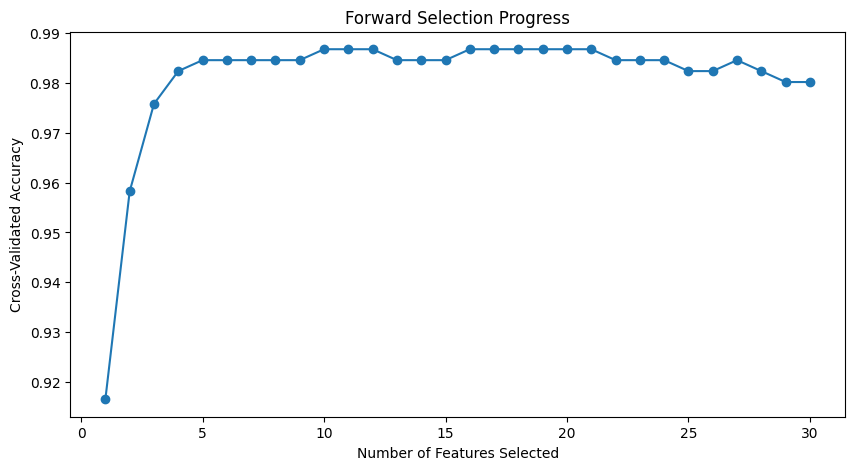

In [37]:
# plot performance over number of features
metric_dict = sfs.get_metric_dict()
scores = [metric_dict[i]["avg_score"] for i in range(1, len(metric_dict) + 1)]

plt.figure(figsize=(10,5))
plt.plot(range(1, len(scores)+1), scores, marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Forward Selection Progress")
plt.show()


## When to Use Forward Selection (SFS)?

- When you have **many features** and want to find the most useful subset instead of blindly using them all.  
- When you care about **interpretability** (smaller feature sets are easier to explain to non-technical people).  
- When you suspect that **not all features are relevant** and some may add noise.  
- When you’re working with **medium-sized datasets** where training multiple models is still feasible.  

Example:  
Imagine you’re predicting whether a patient has a disease. The dataset has 30 medical measurements.  
Doctors don’t want to rely on all 30 — they’d prefer 5–10 strong indicators that make sense clinically.  
SFS helps here by picking the most relevant measurements while keeping accuracy high.  

---

## Problems with Forward Selection (SFS)

- **Computationally expensive**: It trains the model many times, especially if you have hundreds of features.  
- **Greedy approach**: Once it adds a feature, it doesn’t go back and reconsider.  
  - Example: It might pick a feature early on that looks good alone, but later it turns out not to be useful with others. Too late — it’s already locked in.  
- **Risk of overfitting**: If dataset is small, SFS might “cherry-pick” features that look good on cross-validation but don’t generalize well.  
- **Not great for very high-dimensional data** (like gene expression or NLP with thousands of features). In such cases, filter methods or embedded methods (like Lasso) are more practical.  

---

**In short:** Use SFS when you want **interpretability + solid performance** on medium datasets.  
Avoid it when you’re working with **huge feature spaces** or need **fast feature selection**.  


# 3 .Backward Elimination

## What is Backward Elimination?
Backward Elimination is the **opposite of Forward Selection**.  
Instead of starting with no features, it starts with **all features** and then removes them one by one.  
At each step, it drops the feature that contributes the least to the model’s performance.  

Think of it as “peeling an onion”:  
- Start with everything.  
- Keep removing the weakest layer (feature) at each step.  
- Stop when removing more layers starts hurting performance.

---

## Intuition
Imagine you’re packing your travel bag.  
- At first, you throw in **all items** (clothes, shoes, books, gadgets).  
- But your bag is too heavy.  
- So you start removing items that you need the least (like the extra pair of shoes or that heavy book).  
- Finally, you’re left with a **light but useful bag** that still has everything important.  

That’s exactly what Backward Elimination does with features.
